In [3]:
%matplotlib inline

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Study on the Football Statistics and the Correctness of the Odds
### by Kalin Primov

## Abstract
.......

## Introduction
The goal of this study is to see to what extend the odds, which bookmakers assign to games can be used in predicting the final outcome. The data with the odds is taken from *oddsportal* and the data with the games is taken from various sources. Also would be measured the accuracy of odds such as both teams to score, more or less than 2.5 goals and both team to or not to score. The data is for the five major leagues - La Liga, Premier League, Bundesliga, Ligue 1 and Seria A and we will see where and how the predictions and reality are different for the leagues.

## Data Manipulation

### Data Collection
The data is divided into 2 datasets in the '''ginf.csv''' is the data from the _odsportal_ with the odds for the games. The columns in the dataset are:
* id_odsp - unique game identifier
* link_odsp - link to oddsportal page
* adv_stats - boolean if the game has detailed event data
* data
* league
* season
* ht - home team
* at - away team
* fthg - full time home goals
* ftag - full time away goals
* odd_h - home win odds
* odd_d - draw odds
* odd_a - away win odds
* odd_over - over 2.5 goals odds
* odd_under - under 2.5 goals odds
* odd_bts - both teams to score odds
* odd_bts_n - both teams not to score odds
In the ```events.csv``` is the data from the events. We will use it to compare it with the data from ```ginf.csv``` and see if there are other factor, which affect games. The columns in the dataset are:
* id_odsp - unique game identifier
* id_event - unique identifier of event (id_odsp + sort_order)
* sort_order - chronological sequence of events in a game
* time - minutes of the game
* text - text commentary
* event_type - primary event. 11 unique events
* event_type2 - secondary event. 4 unique events
* side - 1-Home, 2-Away
* event_team - team that produced the event
* opponent - team that the event happened against
* player - name of the player involved in the main event
* player2 - name of player involved in secondary event
* player_in - substitude in
* player_out - substitude out
* shot_place - 13 possible placements of the shot
* shot_outcome
* is_goal
* location - location on the pitch
* bodypart
* assist_method
* situation
* fast_break

In [6]:
odds_data = pd.read_csv('data/ginf.csv')
events_data = pd.read_csv('data/events.csv')

(10112, 18)


Most of the stats are given index and the index corresponds to the dictionary. In the dictionary is the full meaning if the values in the columns.

In [45]:
encoding = pd.read_csv('data/dictionary.txt', sep='\t', index_col=0, names=('id', 'event_type'), header=None)
event_type=encoding[1:12]
event_type_2=encoding[14:18]
side=encoding[19:21]
shot_place=encoding[22:35]
shot_outcome=encoding[36:40]
location=encoding[41:60]
bodypart=encoding[61:64]
assist_method=encoding[65:70]
situition=encoding[71:75]

In [35]:
event_type

,event_type
id,
0,Announcement
1,Attempt
2,Corner
3,Foul
4,Yellow card
5,Second yellow card
6,Red card
7,Substitution
8,Free kick won


In [36]:
event_type_2

,event_type
id,
12,Key Pass
13,Failed through ball
14,Sending off
15,Own goal


In [37]:
side

,event_type
id,
1,Home
2,Away


In [38]:
shot_place

,event_type
id,
1,Bit too high
2,Blocked
3,Bottom left corner
4,Bottom right corner
5,Centre of the goal
6,High and wide
7,Hits the bar
8,Misses to the left
9,Misses to the right


In [39]:
shot_outcome

,event_type
id,
1,On target
2,Off target
3,Blocked
4,Hit the bar


In [40]:
location

,event_type
id,
1,Attacking half
2,Defensive half
3,Centre of the box
4,Left wing
5,Right wing
6,Difficult angle and long range
7,Difficult angle on the left
8,Difficult angle on the right
9,Left side of the box


In [41]:
bodypart

,event_type
id,
1,right foot
2,left foot
3,head


In [42]:
assist_method

,event_type
id,
0,None
1,Pass
2,Cross
3,Headed pass
4,Through ball


In [43]:
situition

,event_type
id,
1,Open play
2,Set piece
3,Corner
4,Free kick


## When Goals are Scored
Lets see when the teams score moast and does this corrensponds to the odds.

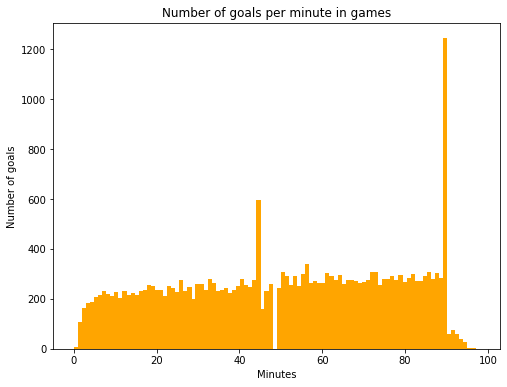

In [54]:
events_data['is_goal'] = events_data['is_goal'].astype('bool')
goals = events_data[events_data['is_goal']]
fig=plt.figure(figsize=(8,6))
plt.hist(goals.time,width=1,bins=100,color="orange")
plt.xlabel("Minutes")
plt.ylabel("Number of goals")
plt.title("Number of goals per minute in games")
plt.show()